In [ ]:
# 对/lustre/home/hangqian/data/zircons/Roberts_Spencer_2015.csv的贝叶斯拐点分析
# time bins个数：200
# 拐点个数：1
# 每核采样数：10000
# 每核burn数：1000（默认）

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

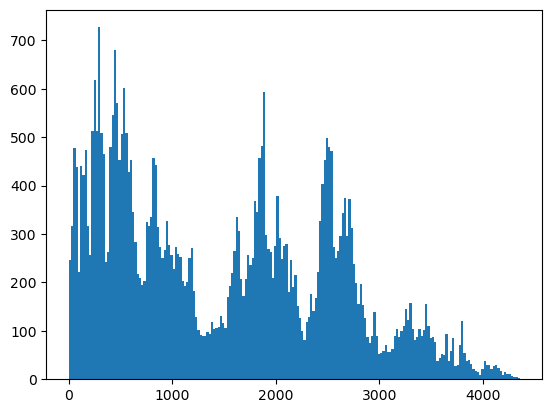

In [2]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import pandas as pd

df = pd.read_csv('/lustre/home/hangqian/data/zircons/Roberts_Spencer_2015.csv')
ages = df["U-Pb (Ma)"]
data = plt.hist(ages, bins = 200)

In [3]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.7.1


In [4]:
print(data)
print(type(data[0]),type(data[1]))

(array([246., 317., 477., 439., 221., 440., 421., 474., 317., 257., 513.,
       619., 513., 727., 509., 466., 242., 262., 479., 545., 680., 571.,
       452., 507., 602., 508., 428., 452., 345., 284., 217., 209., 195.,
       202., 324., 316., 335., 458., 442., 315., 274., 250., 266., 326.,
       277., 257., 227., 273., 259., 253., 203., 192., 201., 251., 271.,
       183., 129., 102.,  92.,  89.,  90.,  97.,  94., 119., 103., 105.,
       109., 131., 117., 106., 170., 193., 220., 265., 336., 306., 207.,
       171., 207., 257., 237., 250., 368., 345., 458., 481., 594., 299.,
       269., 262., 210., 276., 378., 292., 249., 276., 279., 181., 246.,
       190., 215., 151., 126., 100.,  81., 119., 129., 177., 140., 168.,
       222., 326., 404., 453., 498., 480., 471., 273., 251., 264., 295.,
       343., 374., 296., 373., 312., 238., 199., 156., 196., 153., 126.,
        88.,  74.,  90., 138.,  89.,  53.,  54.,  58.,  71.,  57.,  57.,
        62.,  89., 104.,  87.,  99., 111., 146., 1

In [5]:
zircons_data = data[0]
ages = data[1][1:]

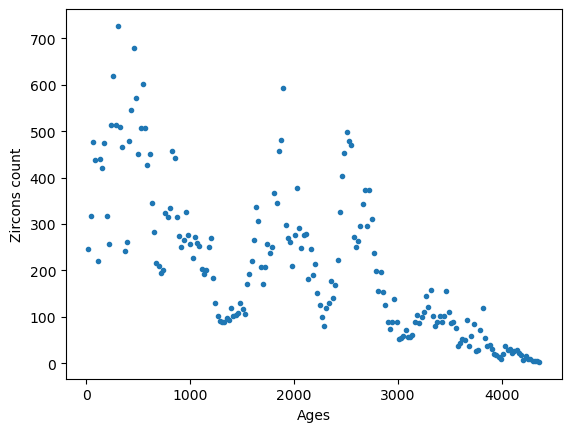

In [6]:
plt.plot(ages, zircons_data, "o", markersize=3, alpha=1)
plt.ylabel("Zircons count")
plt.xlabel("Ages");

In [7]:
ages_nominal = np.arange(len(ages))

In [8]:
with pm.Model() as zircons_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=ages_nominal.min(), upper=ages_nominal.max())

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= ages_nominal, early_rate, late_rate)

    disasters = pm.Poisson("counts", rate, observed=zircons_data)

In [9]:
with zircons_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
/lustre/home/hangqian/miniconda3/envs/pymc_env5/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


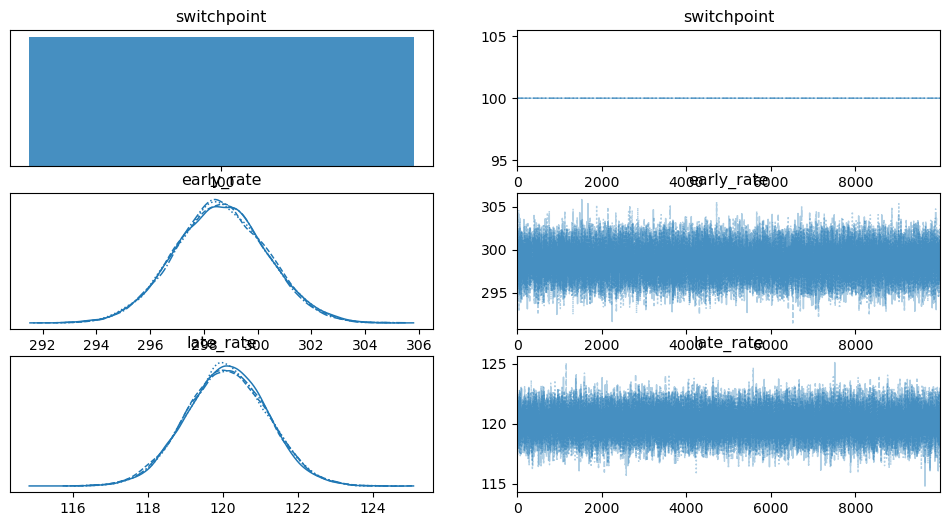

In [10]:
axes_arr = pm.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        #ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

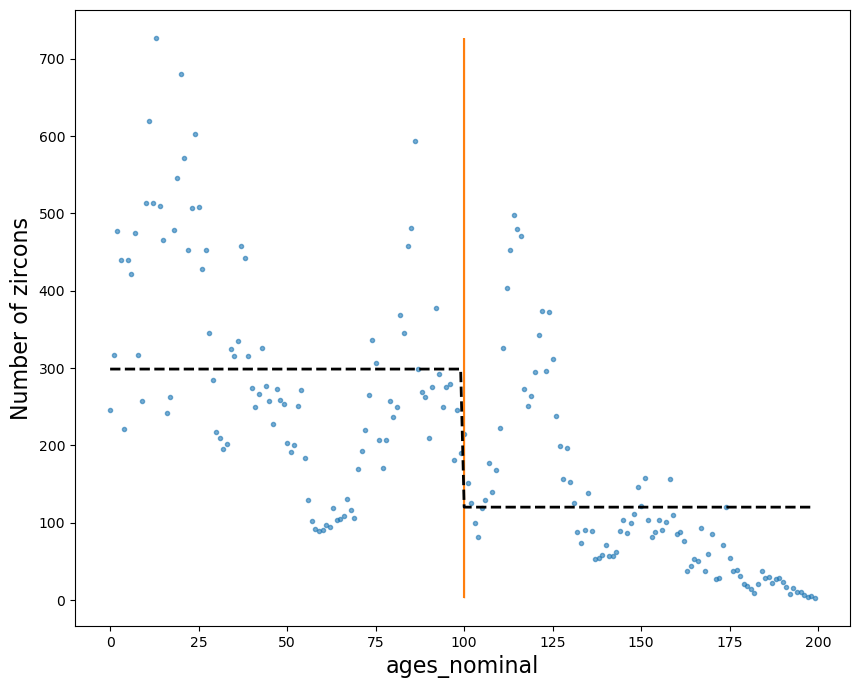

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(ages_nominal, zircons_data, ".", alpha=0.6)
plt.ylabel("Number of zircons", fontsize=16)
plt.xlabel("ages_nominal", fontsize=16)

trace = idata.posterior.stack(draws=("chain", "draw"))

plt.vlines(trace["switchpoint"].mean(), zircons_data.min(), zircons_data.max(), color="C1")
average_zircons = np.zeros_like(zircons_data, dtype="float")
for i, year in enumerate(ages_nominal):
    idx = year < trace["switchpoint"]
    average_zircons[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))

sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[zircons_data.min(), zircons_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(ages_nominal, average_zircons, "k--", lw=2);